In [61]:
import copy
import json
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

from preprocessing import PreProcessing

## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [2]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [3]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [4]:
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726


In [5]:
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46751,1.05000,0.44966,0.41572,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46790,1.05000,0.44983,0.41550,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46818,1.05000,0.44997,0.41485,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46855,1.05000,0.45017,0.41515,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891


## Tracking for individual Players Visualization

In [6]:
# player_tracking(period_1_data)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Adding extra features to dataset

In [7]:
vel_acc_game_1_data = game_1_pre.vel_acc(game_1_data)
vel_acc_game_2_data = game_2_pre.vel_acc(game_2_data)

In [8]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.151215,NaN
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.123138,-0.701914
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.011138,0.278458,0.019121,0.478033,0.015201,0.380019,0.029611,0.740275,0.415521,-17.690434
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.008515,-0.065591,0.011560,-0.189042,0.022103,0.172568,0.029100,-0.012774,0.417319,0.044937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.010198,0.098326,0.002704,0.017604,0.013613,0.028951,0.017509,0.062515,0.000000,0.000000
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.004031,-0.154173,0.011319,0.215377,0.014346,0.018330,0.022407,0.122446,0.000000,0.000000
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.009394,0.134075,0.007906,-0.085338,0.013829,-0.012921,0.009100,-0.332665,0.000000,0.000000
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.013500,0.102646,0.013440,0.138350,0.015004,0.029371,0.007754,-0.033653,0.000000,0.000000


In [9]:
vel_acc_game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00875,0.06250,0.010000,-0.027615,0.0,0.0,0.0,0.0,0.0,0.0
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00975,0.02500,0.006951,-0.076232,0.0,0.0,0.0,0.0,0.0,0.0
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00700,-0.06875,0.016623,0.241798,0.0,0.0,0.0,0.0,0.0,0.0
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00925,0.05625,0.009014,-0.190219,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]

In [11]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00875,0.06250,0.010000,-0.027615,0.0,0.0,0.0,0.0,0.0,0.0
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00975,0.02500,0.006951,-0.076232,0.0,0.0,0.0,0.0,0.0,0.0
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00700,-0.06875,0.016623,0.241798,0.0,0.0,0.0,0.0,0.0,0.0
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00925,0.05625,0.009014,-0.190219,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# game_1_players, game_1_vel_acc = game_1_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_1_ply_tra.loc[:,"P_1_velocity":]
# game_2_players, game_2_vel_acc = game_2_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_2_ply_tra.loc[:,"P_1_velocity":]

In [13]:
game_1_player_data = game_1_pre.get_frames(game_1_ply_tra, columns=game_1_ply_tra.columns[0:46:2]).round(3).fillna(0)
game_2_player_data = game_2_pre.get_frames(game_2_ply_tra, columns=game_2_ply_tra.columns[0:46:2]).round(3).fillna(0)

In [14]:
game_2_player_data

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration,Ball-x,Ball-y,Ball_velocity,Ball_acceleration
1,0.943,0.504,0.0,0.0,0.648,0.286,0.0,0.0,0.678,0.428,...,0.0,0.0,0.495,0.362,0.0,0.0,0.502,0.504,0.0,0.0
2,0.943,0.504,0.0,0.0,0.648,0.286,0.0,0.0,0.678,0.428,...,0.0,0.0,0.495,0.362,0.0,0.0,0.502,0.504,0.0,0.0
3,0.943,0.504,0.0,0.0,0.648,0.286,0.0,0.0,0.678,0.428,...,0.0,0.0,0.495,0.362,0.0,0.0,0.502,0.504,0.0,0.0
4,0.943,0.504,0.0,0.0,0.648,0.286,0.0,0.0,0.678,0.428,...,0.0,0.0,0.495,0.362,0.0,0.0,0.502,0.504,0.0,0.0
5,0.943,0.504,0.0,0.0,0.648,0.286,0.0,0.0,0.678,0.428,...,0.0,0.0,0.495,0.362,0.0,0.0,0.502,0.504,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.063,0.512,0.0,0.0,0.385,0.154,0.0,0.0,0.226,0.414,...,0.0,0.0,0.368,0.125,0.0,0.0,0.410,-0.039,0.0,0.0
141153,0.063,0.512,0.0,0.0,0.385,0.154,0.0,0.0,0.226,0.414,...,0.0,0.0,0.368,0.125,0.0,0.0,0.410,-0.039,0.0,0.0
141154,0.063,0.512,0.0,0.0,0.385,0.154,0.0,0.0,0.226,0.414,...,0.0,0.0,0.368,0.125,0.0,0.0,0.410,-0.039,0.0,0.0
141155,0.063,0.512,0.0,0.0,0.385,0.154,0.0,0.0,0.226,0.414,...,0.0,0.0,0.368,0.125,0.0,0.0,0.410,-0.039,0.0,0.0


# Classification

In [15]:
def change_player_name(data: pd.Series) -> pd.Series:
    result = []
    name = ""
    for i in range(len(data)):
        item = data.iloc[i]
        if len(item) == 8:
            if int(item[-2:]) < 12:
                name = f"Home-P_{item[-2:]}"
            else:
                name = f"Away-P_{item[-2:]}"
        else:
            name = f"Home-P_{item[-1:]}"
            
        result.append(name)

    return pd.Series(data=result, name=data.name)

In [16]:
game_1_event_data = pd.read_csv("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv")
game_2_event_data = pd.read_csv("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv")

In [17]:
game_1_event_data

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,Home,PASS,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,0.60,0.33,0.19,0.95
1741,Home,PASS,NaN,2,143578,5743.12,143593,5743.72,Player13,Player4,0.09,0.88,0.14,0.69
1742,Home,BALL LOST,INTERCEPTION,2,143598,5743.92,143618,5744.72,Player4,NaN,0.13,0.69,0.07,0.61
1743,Away,RECOVERY,BLOCKED,2,143617,5744.68,143617,5744.68,Player16,NaN,0.05,0.62,NaN,NaN


In [18]:
game_1_event_data = game_1_event_data[~(game_1_event_data["Type"] == "FAULT RECEIVED")]
game_2_event_data = game_2_event_data[~(game_2_event_data["Type"] == "FAULT RECEIVED")]

game_1_event_data = game_1_event_data.replace("RECOVERY", "BALL LOST")
game_2_event_data = game_2_event_data.replace("RECOVERY", "BALL LOST")

In [19]:
game_2_event_data

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,0.54,0.77,0.29,0.24
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,0.31,0.30,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,0.32,0.30,NaN,NaN
1933,Home,BALL LOST,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,0.34,0.32,NaN,NaN


In [20]:
game_1_event_data = game_1_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]
game_2_event_data = game_2_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]

In [21]:
game_1_event_data.sample(5)

,Type,Start Frame,End Frame,From,To
981,PASS,78797,78837,Player16,Player15
531,CHALLENGE,43171,43171,Player7,NaN
217,SET PIECE,15917,15917,Player3,NaN
1428,PASS,117274,117289,Player13,Player5
1668,PASS,136381,136413,Player23,Player21


In [22]:
game_2_event_data.sample(5)

,Type,Start Frame,End Frame,From,To
253,BALL LOST,16499,16499,Player25,NaN
497,PASS,31380,31433,Player5,Player6
1655,SET PIECE,111368,111368,Player24,NaN
57,PASS,2789,2811,Player5,Player6
115,BALL LOST,6602,6630,Player1,NaN


In [23]:
def fix_events(event_dataset):
    fixed_event_df = event_dataset.copy()
    
    start_frames = fixed_event_df["Start Frame"].values
    end_frames = fixed_event_df["End Frame"].values
    
    conflict_indices = np.where(start_frames[1:] == end_frames[:-1])[0] + 1
    
    fixed_event_df.loc[fixed_event_df.index[conflict_indices], "Start Frame"] += 1
    
    return fixed_event_df

In [24]:
# game_1_event_data = fix_events(game_1_event_data)
# game_2_event_data = fix_events(game_2_event_data)

In [25]:
game_1_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,1,0,Player19,NaN
1,PASS,1,3,Player19,Player21
2,PASS,3,17,Player21,Player15
3,PASS,45,61,Player15,Player19
4,PASS,77,96,Player19,Player21
...,...,...,...,...,...
1740,PASS,143361,143483,Player12,Player13
1741,PASS,143578,143593,Player13,Player4
1742,BALL LOST,143598,143618,Player4,NaN
1743,BALL LOST,143617,143617,Player16,NaN


In [26]:
start_frames = game_1_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_1_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_1_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_1_player_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
game_1_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_1_event.loc[s:e, "Type"] = e_t

game_1_event = game_1_event.fillna("")

In [27]:
start_frames = game_2_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_2_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_2_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_2_player_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
game_2_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_2_event.loc[s:e, "Type"] = e_t

game_2_event = game_2_event.fillna("")

In [28]:
game_1_event

,Type
1,PASS
2,PASS
3,PASS
4,PASS
5,PASS
...,...
143626,BALL OUT
143627,BALL OUT
143628,BALL OUT
143629,BALL OUT


In [29]:
game_2_event

,Type
51,PASS
52,PASS
53,PASS
54,PASS
55,PASS
...,...
140294,BALL OUT
140295,BALL OUT
140296,BALL OUT
140297,BALL OUT


In [30]:
common_indices = game_1_event.index.intersection(game_1_player_data.index)
X_1 = game_1_player_data.loc[common_indices]
y_1 = game_1_event.loc[common_indices, "Type"]

In [31]:
common_indices = game_2_event.index.intersection(game_2_player_data.index)
X_2 = game_2_player_data.loc[common_indices]
y_2 = game_2_event.loc[common_indices, "Type"]

In [ ]:
# X_1 = game_1_pre.expand_dataset(dataset=X_1, look_back=50)
# X_2 = game_2_pre.expand_dataset(dataset=X_2, look_back=50)

# y_1 = game_1_pre.expand_dataset(dataset=y_1, look_back=50)
# y_2 = game_2_pre.expand_dataset(dataset=y_2, look_back=50)

In [ ]:
def create_segments_multifeature(data, label, segment_length):
    inputs = []
    outputs = []
    
    assert len(data) == len(label), "Data and label lengths must match"
    
    for i in range(0, len(data) - segment_length + 1, segment_length):
        input_segment = data.iloc[i:i + segment_length].values
        label_segment = label.iloc[i:i + segment_length].values
        
        if len(input_segment) == segment_length:
            inputs.append(input_segment)
            outputs.append(label_segment)
            
    return np.array(inputs), np.array(outputs)

In [ ]:
X_1, y_1 = create_segments_multifeature(X_1, y_1, segment_length=1000)
X_2, y_2 = create_segments_multifeature(X_2, y_2, segment_length=1000)

In [67]:
print(np.unique(y_1, return_counts=True))
print(np.unique(y_2, return_counts=True))

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
       'SHOT'], dtype=object), array([10006,  2871,     4,   132, 28247,    12,   619]))
(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
       'SHOT'], dtype=object), array([ 7681,  2454,     6,   172, 32469,     9,   543]))


# New Dataset

In [32]:
game_3_data = pd.read_csv("data/Sample_Game_3/Sample_Game_3_tracking.txt", sep=r"[;,:]", header=None, engine="python")
game_3_data.index =  range(1, len(game_3_data) + 1)

In [33]:
time = np.arange(0.04, (len(game_3_data) + 1) * 0.04, 0.04).round(2)
game_3_data.insert(1, "Time [s]", time)

In [34]:
columns = ['Frame', 'Time [s]', 'Home-Player11-x', 'Home-Player11-y', 'Home-Player1-x', 'Home-Player1-y', 'Home-Player2-x', 'Home-Player2-y',
       'Home-Player3-x', 'Home-Player3-y', 'Home-Player4-x', 'Home-Player4-y', 'Home-Player5-x', 'Home-Player5-y', 'Home-Player6-x', 'Home-Player6-y',
       'Home-Player7-x', 'Home-Player7-y', 'Home-Player8-x', 'Home-Player8-y', 'Home-Player9-x', 'Home-Player9-y', 'Home-Player10-x',
       'Home-Player10-y', 'Away-Player25-x', 'Away-Player25-y', 'Away-Player15-x', 'Away-Player15-y', 'Away-Player16-x',
       'Away-Player16-y', 'Away-Player17-x', 'Away-Player17-y', 'Away-Player18-x', 'Away-Player18-y', 'Away-Player19-x',
       'Away-Player19-y', 'Away-Player20-x', 'Away-Player20-y', 'Away-Player21-x', 'Away-Player21-y', 'Away-Player22-x',
       'Away-Player22-y', 'Away-Player23-x', 'Away-Player23-y', 'Away-Player24-x', 'Away-Player24-y', "Ball-x", "Ball-y"]

game_3_data.columns = columns

In [35]:
game_3_data = game_2_pre._fill_missing_with_interpolation_and_fill(game_3_data)

In [36]:
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,0.50125,0.48725
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,0.50125,0.48725
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,0.50125,0.48725
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,0.50125,0.48725
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,0.89207,0.50485
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,0.89207,0.50485
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,0.89207,0.50485
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,0.89207,0.50485


In [37]:
vel_acc_game_3_data = game_1_pre.vel_acc(game_3_data)
vel_acc_game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.058045,NaN,0.131646,NaN,0.004507,NaN,0.007603,NaN,0.0,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.011413,-1.165813,0.024251,-2.684858,0.010753,0.156149,0.005590,-0.050332,0.0,0.0
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.003750,-0.191568,0.035672,0.285521,0.014182,0.085724,0.024079,0.462228,0.0,0.0
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.016978,0.330698,0.005056,-0.765405,0.012415,-0.044179,0.009763,-0.357912,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.016508,0.052893,0.012260,0.120679,0.006828,0.061555,0.016900,-0.017704,0.0,0.0
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.023352,0.171109,0.014346,0.052149,0.013647,0.170477,0.027933,0.275813,0.0,0.0
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.035435,0.302072,0.019416,0.126758,0.021588,0.198528,0.035588,0.191374,0.0,0.0
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.035772,0.008426,0.026450,0.175848,0.036566,0.374435,0.034792,-0.019892,0.0,0.0


In [38]:
game_3_ply_tra = vel_acc_game_3_data.iloc[:, 2:]
game_3_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,0.62405,0.80669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,0.62371,0.80594,...,0.058045,NaN,0.131646,NaN,0.004507,NaN,0.007603,NaN,0.0,NaN
3,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,0.62354,0.80601,...,0.011413,-1.165813,0.024251,-2.684858,0.010753,0.156149,0.005590,-0.050332,0.0,0.0
4,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,0.62318,0.80604,...,0.003750,-0.191568,0.035672,0.285521,0.014182,0.085724,0.024079,0.462228,0.0,0.0
5,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,0.62286,0.80626,...,0.016978,0.330698,0.005056,-0.765405,0.012415,-0.044179,0.009763,-0.357912,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,0.50927,0.27457,...,0.016508,0.052893,0.012260,0.120679,0.006828,0.061555,0.016900,-0.017704,0.0,0.0
143758,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,0.50913,0.27654,...,0.023352,0.171109,0.014346,0.052149,0.013647,0.170477,0.027933,0.275813,0.0,0.0
143759,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,0.50876,0.27762,...,0.035435,0.302072,0.019416,0.126758,0.021588,0.198528,0.035588,0.191374,0.0,0.0
143760,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,0.50808,0.27935,...,0.035772,0.008426,0.026450,0.175848,0.036566,0.374435,0.034792,-0.019892,0.0,0.0


In [39]:
game_3_player_data = game_1_pre.get_frames(game_3_ply_tra, columns=game_3_ply_tra.columns[0:46:2]).round(3).fillna(0)
game_3_player_data

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration,Ball-x,Ball-y,Ball_velocity,Ball_acceleration
1,0.847,0.529,0.0,0.0,0.653,0.248,0.000,0.000,0.665,0.466,...,0.000,0.000,0.489,0.364,0.000,0.000,0.501,0.487,0.0,0.0
2,0.847,0.529,0.0,0.0,0.652,0.245,0.070,0.000,0.665,0.465,...,0.005,0.000,0.488,0.364,0.008,0.000,0.501,0.487,0.0,0.0
3,0.847,0.529,0.0,0.0,0.652,0.244,0.033,-0.943,0.665,0.465,...,0.011,0.156,0.488,0.364,0.006,-0.050,0.501,0.487,0.0,0.0
4,0.847,0.529,0.0,0.0,0.652,0.243,0.026,-0.167,0.665,0.465,...,0.014,0.086,0.488,0.363,0.024,0.462,0.501,0.487,0.0,0.0
5,0.847,0.529,0.0,0.0,0.651,0.243,0.011,-0.369,0.665,0.465,...,0.012,-0.044,0.488,0.362,0.010,-0.358,0.501,0.487,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.120,0.518,0.0,0.0,0.478,0.454,0.018,0.206,0.497,0.773,...,0.007,0.062,0.808,0.271,0.017,-0.018,0.892,0.505,0.0,0.0
143758,0.120,0.518,0.0,0.0,0.478,0.455,0.029,0.282,0.497,0.774,...,0.014,0.170,0.807,0.272,0.028,0.276,0.892,0.505,0.0,0.0
143759,0.120,0.518,0.0,0.0,0.477,0.457,0.048,0.486,0.497,0.776,...,0.022,0.199,0.806,0.272,0.036,0.191,0.892,0.505,0.0,0.0
143760,0.120,0.518,0.0,0.0,0.477,0.459,0.062,0.352,0.497,0.776,...,0.037,0.374,0.804,0.273,0.035,-0.020,0.892,0.505,0.0,0.0


In [40]:
with open("data/Sample_Game_3/Sample_Game_3_events.json", "r") as f:
    data = json.load(f)

In [41]:
type_ = np.array([])
start_frame = np.array([])
end_frame = np.array([])

for i in data["data"]:
    t = i["type"]["name"]
    sf = i["start"]["frame"]
    ef = i["end"]["frame"]

    if t != "CARRY":   
        type_ = np.append(type_, t)
        start_frame = np.append(start_frame, sf)
        end_frame = np.append(end_frame, ef)


game_3_event_data = pd.DataFrame({"Type": type_, "Start Frame": start_frame.astype(np.int64), "End Frame": end_frame.astype(np.int64)})

In [42]:
game_3_event_data = game_3_event_data[~(game_3_event_data["Type"] == "FAULT RECEIVED")]

game_3_event_data = game_3_event_data.replace("RECOVERY", "BALL LOST")

In [43]:
game_3_event_data

,Type,Start Frame,End Frame
0,SET PIECE,361,361
1,PASS,361,377
2,PASS,384,426
3,PASS,465,507
4,PASS,530,580
...,...,...,...
2220,PASS,143190,143265
2221,PASS,143265,143290
2222,PASS,143406,143469
2223,PASS,143469,143532


In [44]:
start_frames = game_3_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_3_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_3_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_3_player_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
game_3_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_3_event.loc[s:e, "Type"] = e_t

game_3_event = game_3_event.dropna()

In [45]:
game_3_event

,Type
361,PASS
362,PASS
363,PASS
364,PASS
365,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [46]:
# with open("model.pickle", "rb") as f:
#     loaded_model = pickle.load(f)

In [47]:
common_indices = game_3_event.index.intersection(game_3_player_data.index)
X_3 = game_3_player_data.loc[common_indices]
y_3 = game_3_event.loc[common_indices, "Type"]

In [48]:
X_3.loc[143554] = X_3.loc[105378, :]
y_3.loc[143554] = y_3.loc[105378]

In [49]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
        'SHOT'], dtype=object),
 array([10006,  2871,     4,   132, 28247,    12,   619], dtype=int64))

In [50]:
np.unique(y_2, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
        'SHOT'], dtype=object),
 array([ 7681,  2454,     6,   172, 32469,     9,   543], dtype=int64))

In [51]:
np.unique(y_3, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SHOT'],
       dtype=object),
 array([11080,  2662,     2,   186, 43053,   403], dtype=int64))

In [52]:
scaler = MinMaxScaler()
X_1 = scaler.fit_transform(X_1)
X_2 = scaler.transform(X_2)
X_3 = scaler.transform(X_3)

# label_encoder = LabelEncoder()
# y_1 = label_encoder.fit_transform(y_1)
# y_2 = label_encoder.transform(y_2)
# y_new = label_encoder.transform(y_new)

In [53]:
assert X_3.shape[0] == y_3.shape[0]

In [54]:
# smote = SMOTE(k_neighbors=1)
sme = BorderlineSMOTE(k_neighbors=1)
X_1, y_1 = sme.fit_resample(X_1, y_1)
X_2, y_2 = sme.fit_resample(X_2, y_2)
X_3, y_3 = sme.fit_resample(X_3, y_3)

C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The BorderlineSMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
C:\Users\noill\O

In [55]:
X = np.concatenate([X_1, X_2])
y = np.concatenate((y_1, y_2))

assert X.shape[0] == y.shape[0]

In [57]:
print(np.unique(y, return_counts=True), "\n")
print(np.unique(y_3, return_counts=True))

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
       'SHOT'], dtype=object), array([60716, 60716,    10, 60716, 60716,    21, 60716], dtype=int64)) 

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SHOT'],
      dtype=object), array([43053, 43053, 43053, 43053, 43053, 43053], dtype=int64))


In [58]:
def conf_matrix(y_train, y_train_pred, y_test, y_pred, labels, split, model_name=""):
    fig, ax = plt.subplots(figsize=(12, 10))

    cm_counts = confusion_matrix(y_test, y_pred, labels=labels)
    cm_normalized = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")

    annot = []
    for i in range(len(cm_counts)):
        row_annot = []
        for j in range(len(cm_counts[i])):
            row_annot.append(f"{cm_counts[i, j]} | {cm_normalized[i, j]:.2f}")
        annot.append(row_annot)
    
    sns.heatmap(cm_normalized, 
                annot=annot,
                fmt="", 
                cmap="viridis", 
                xticklabels=labels, 
                yticklabels=labels,
                cbar_kws={"label": "Normalized Frequency"})

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"{model_name.title()} Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)


    print(f"{model_name} training accuracy: {train_accuracy * 100:0.2f}%")
    print(f"{model_name} testing accuracy: {test_accuracy * 100:0.2f}%\n")   
    print(f"{model_name} testing precision: {precision * 100:0.2f}%")
    print(f"{model_name} testing recall: {recall * 100:0.2f}%")
    print(f"{model_name} testing f1: {f1 * 100:0.2f}%\n\n\n")

### Best param for AdaBoost: Best trial: {'n_estimators': 196, 'learning_rate': 0.5139082951204903}
### Best param for Logistic Regression: Best trial: {'C': 1.2827821457799138e-05, 'max_iter': 1000, 'penalty': None}
### Best param for Random Forest: Best trial: {'n_estimators': 79, 'max_features': 'log2'}

In [55]:
import warnings
warnings.filterwarnings("ignore")

models = {
          "AdaBoost classifier": AdaBoostClassifier(algorithm="SAMME", n_estimators=196, learning_rate=0.5139082951204903, random_state=42), 
          "Logistic regression": LogisticRegression(n_jobs=-1, solver="saga", C=1.2827821457799138e-05, max_iter=1000, penalty=None, random_state=42),
          "Random forest classifier": RandomForestClassifier(n_jobs=-1, n_estimators=79, max_features="log2", random_state=42),  
         }

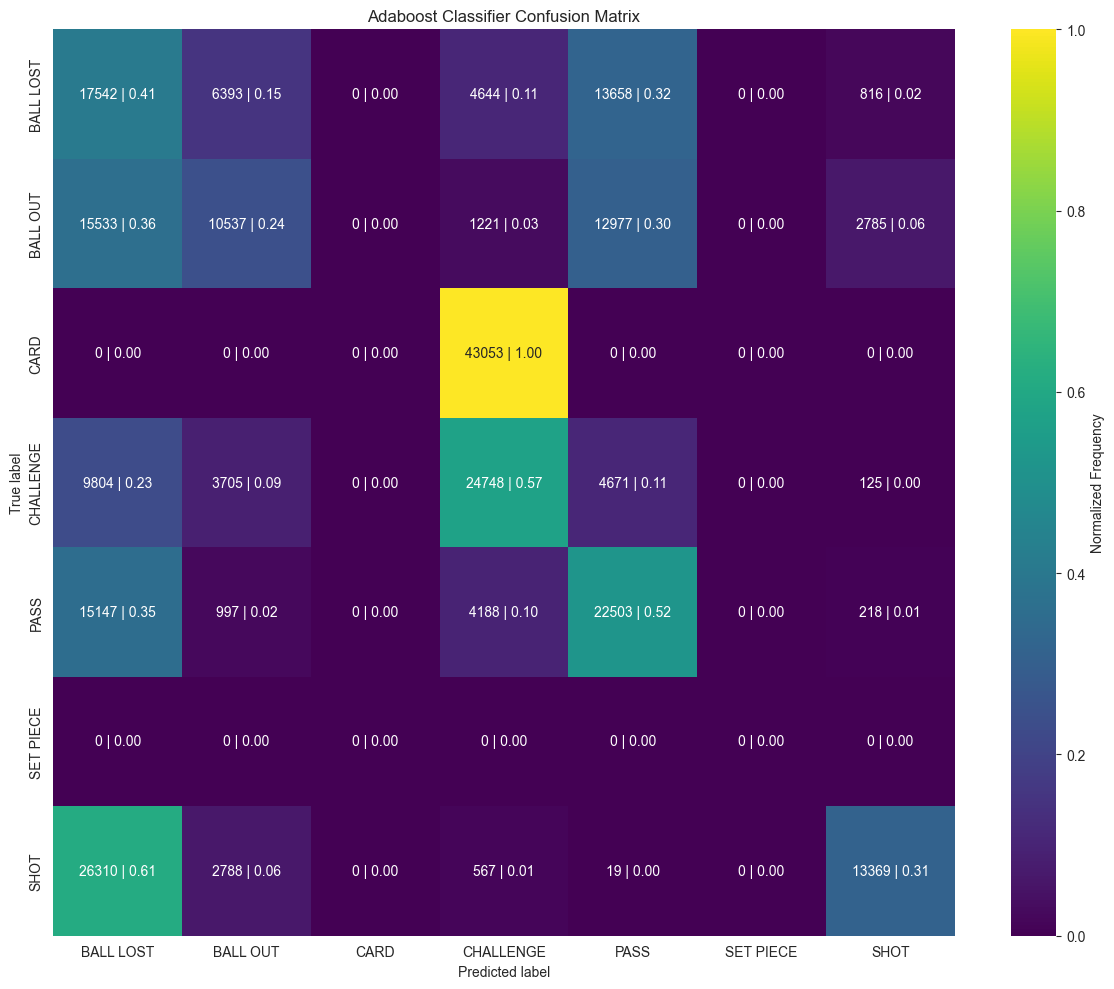

AdaBoost classifier training accuracy: 60.97%
AdaBoost classifier testing accuracy: 34.34%

AdaBoost classifier testing precision: 35.76%
AdaBoost classifier testing recall: 34.34%
AdaBoost classifier testing f1: 31.71%


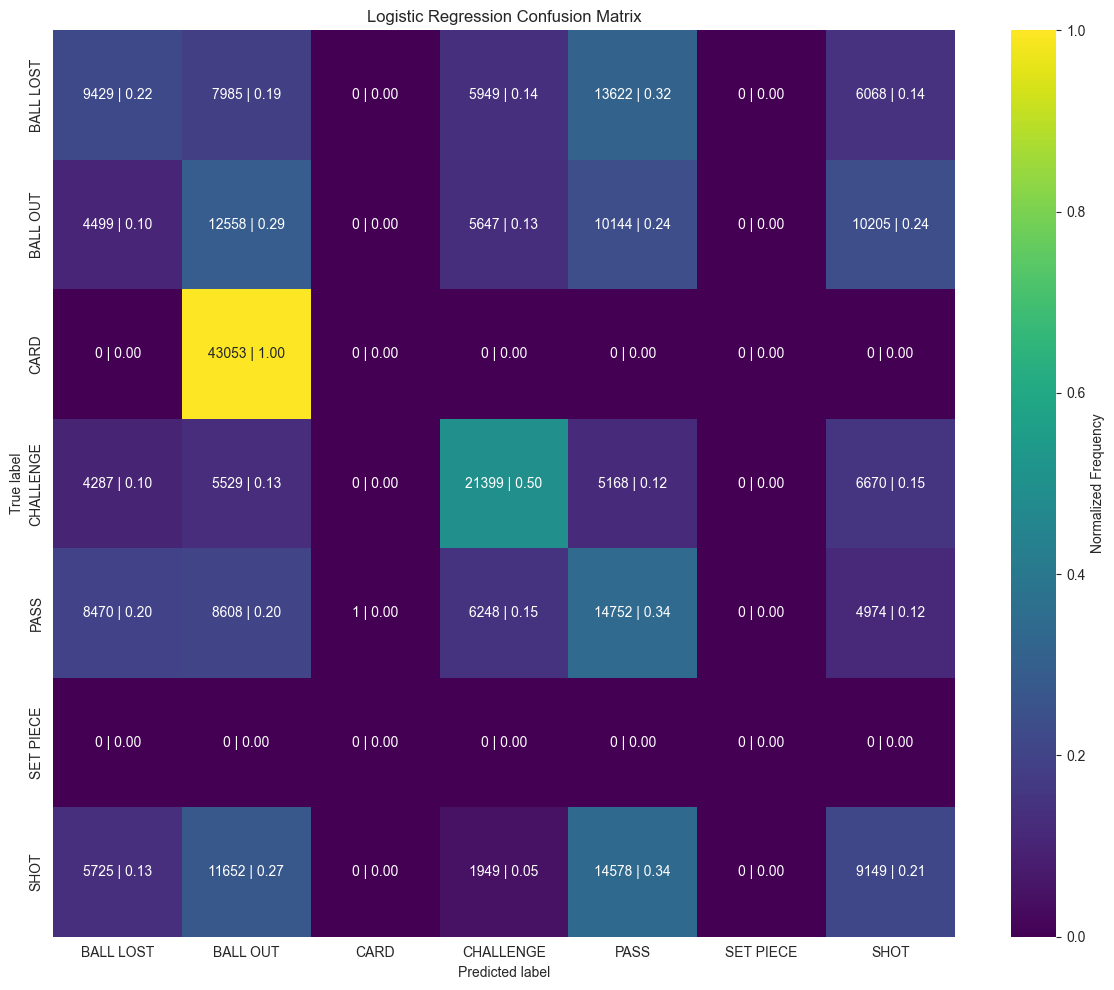

Logistic regression training accuracy: 71.10%
Logistic regression testing accuracy: 26.05%

Logistic regression testing precision: 24.18%
Logistic regression testing recall: 26.05%
Logistic regression testing f1: 24.45%


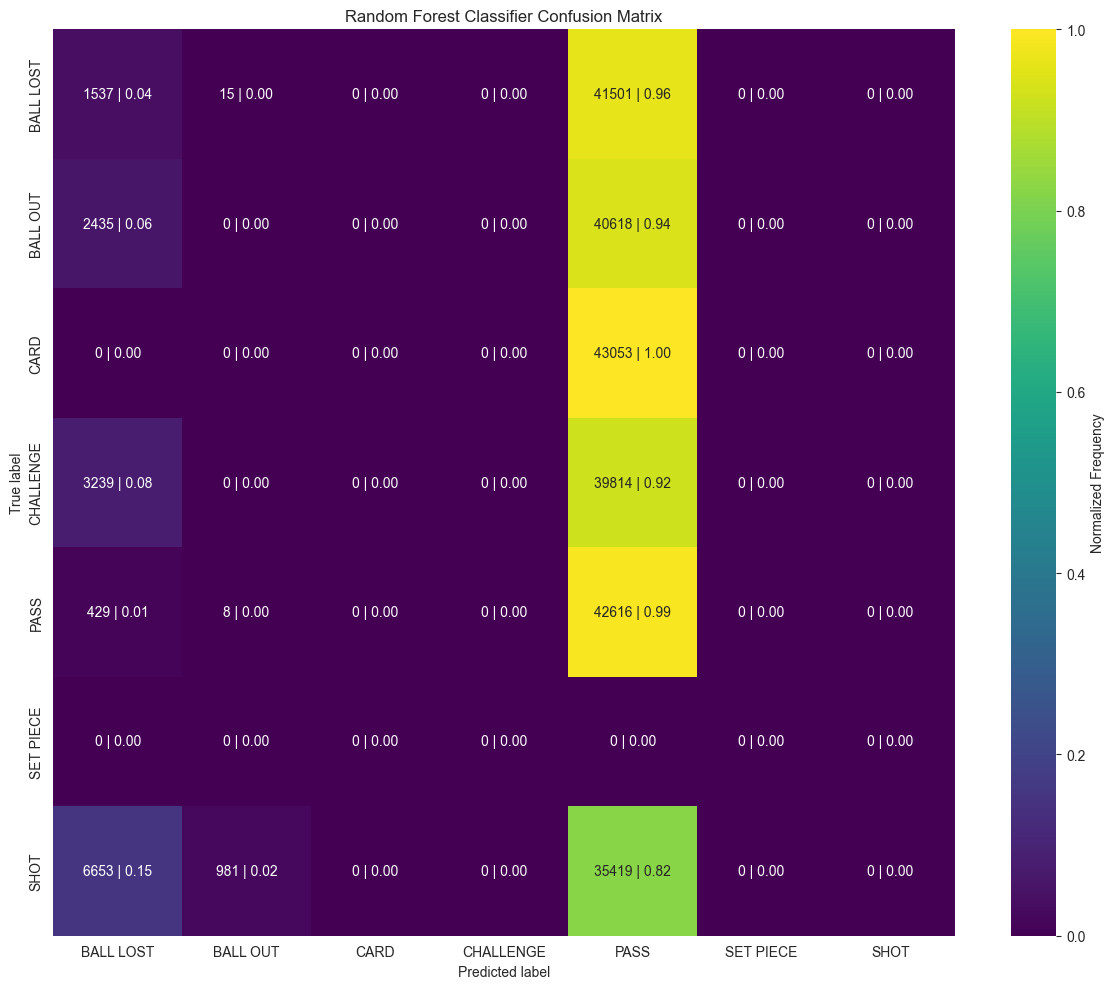

Random forest classifier training accuracy: 100.00%
Random forest classifier testing accuracy: 17.09%

Random forest classifier testing precision: 4.71%
Random forest classifier testing recall: 17.09%
Random forest classifier testing f1: 5.86%


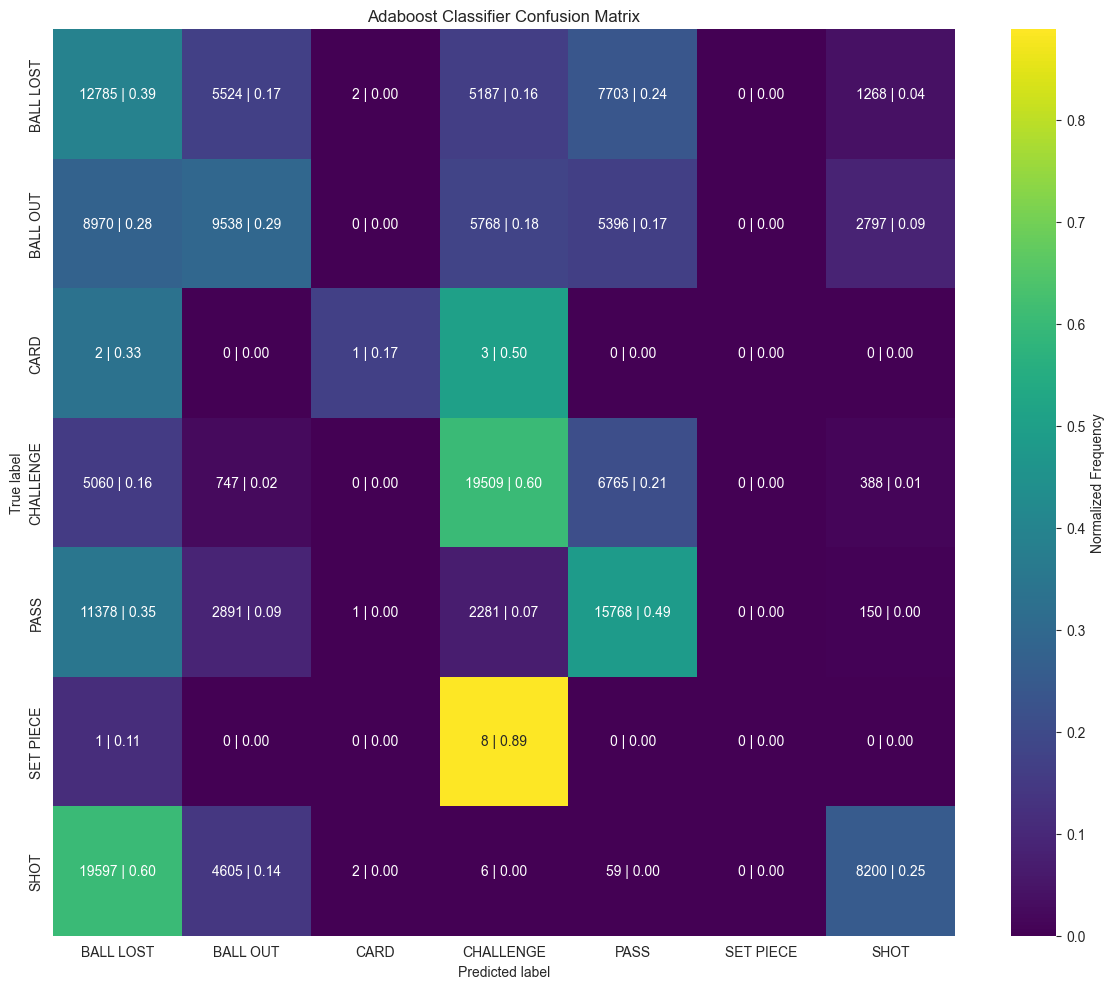

AdaBoost classifier training accuracy: 63.09%
AdaBoost classifier testing accuracy: 40.53%

AdaBoost classifier testing precision: 46.16%
AdaBoost classifier testing recall: 40.53%
AdaBoost classifier testing f1: 40.96%


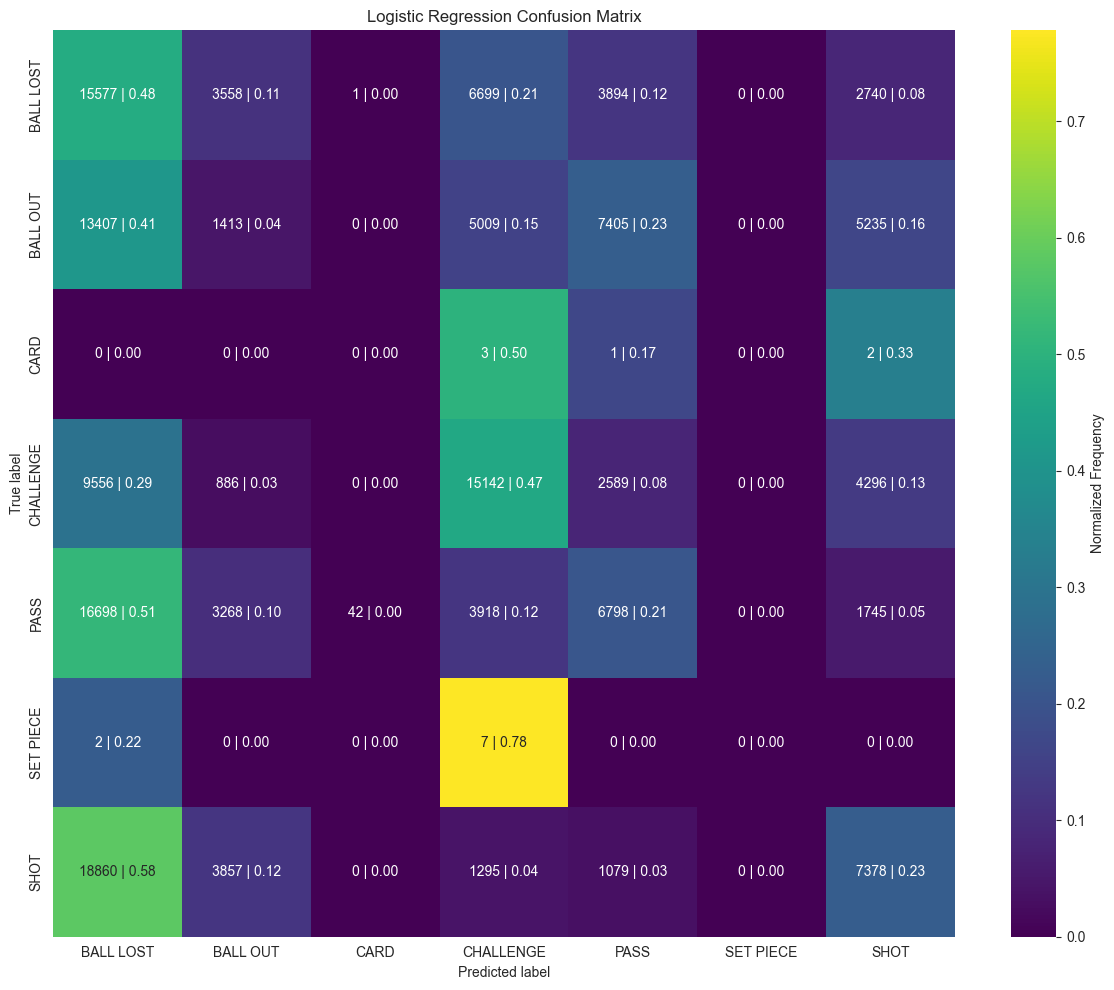

Logistic regression training accuracy: 74.37%
Logistic regression testing accuracy: 28.52%

Logistic regression testing precision: 28.96%
Logistic regression testing recall: 28.52%
Logistic regression testing f1: 26.96%


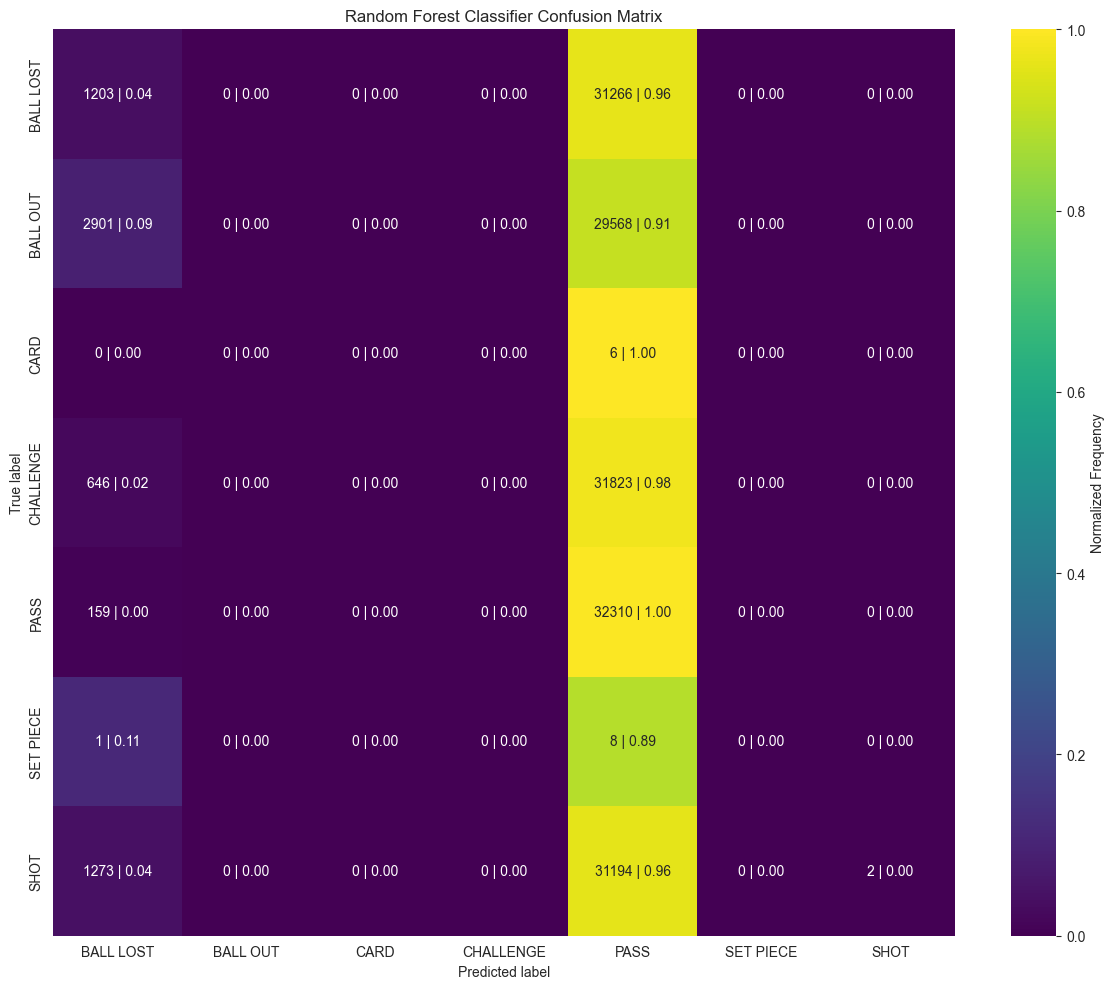

Random forest classifier training accuracy: 100.00%
Random forest classifier testing accuracy: 20.64%

Random forest classifier testing precision: 28.03%
Random forest classifier testing recall: 20.64%
Random forest classifier testing f1: 8.10%


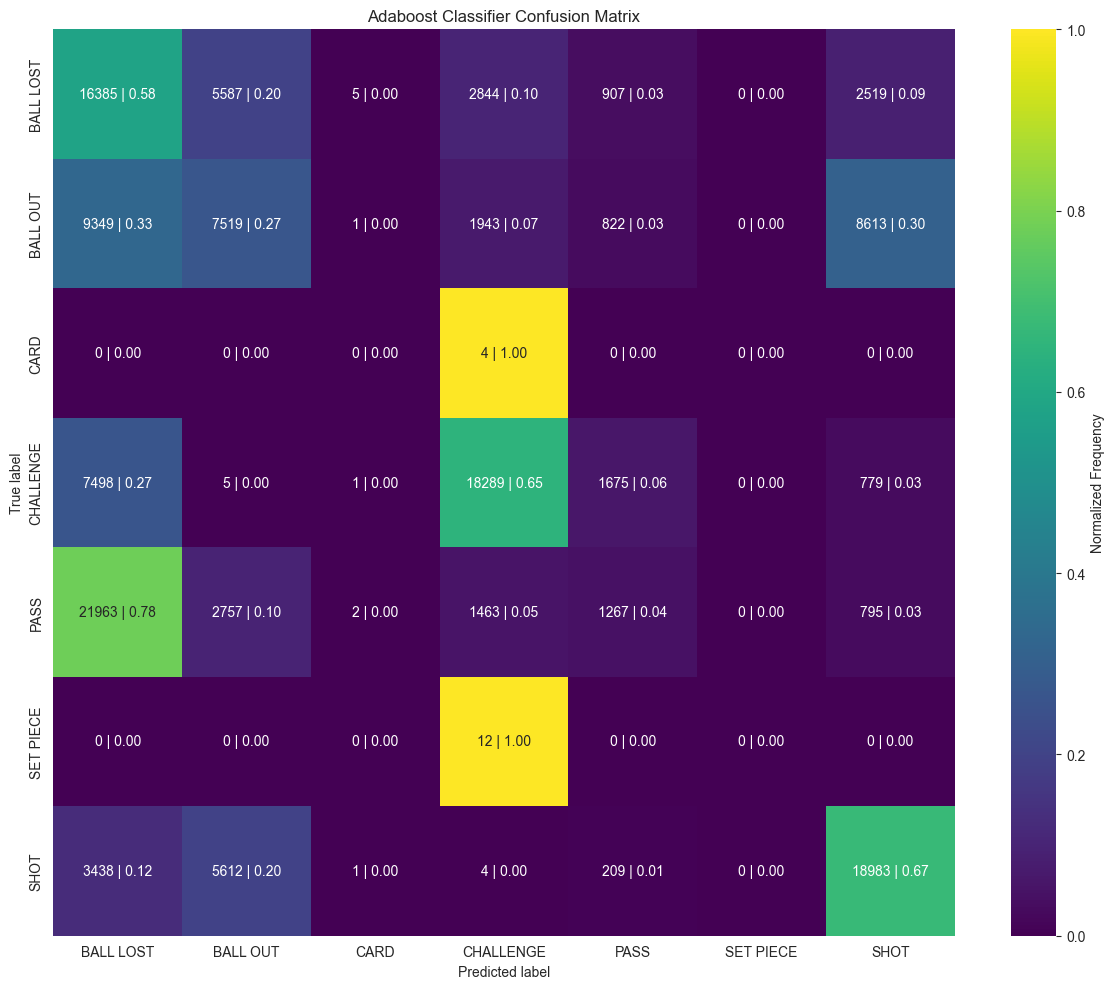

AdaBoost classifier training accuracy: 60.70%
AdaBoost classifier testing accuracy: 44.21%

AdaBoost classifier testing precision: 44.65%
AdaBoost classifier testing recall: 44.21%
AdaBoost classifier testing f1: 41.64%


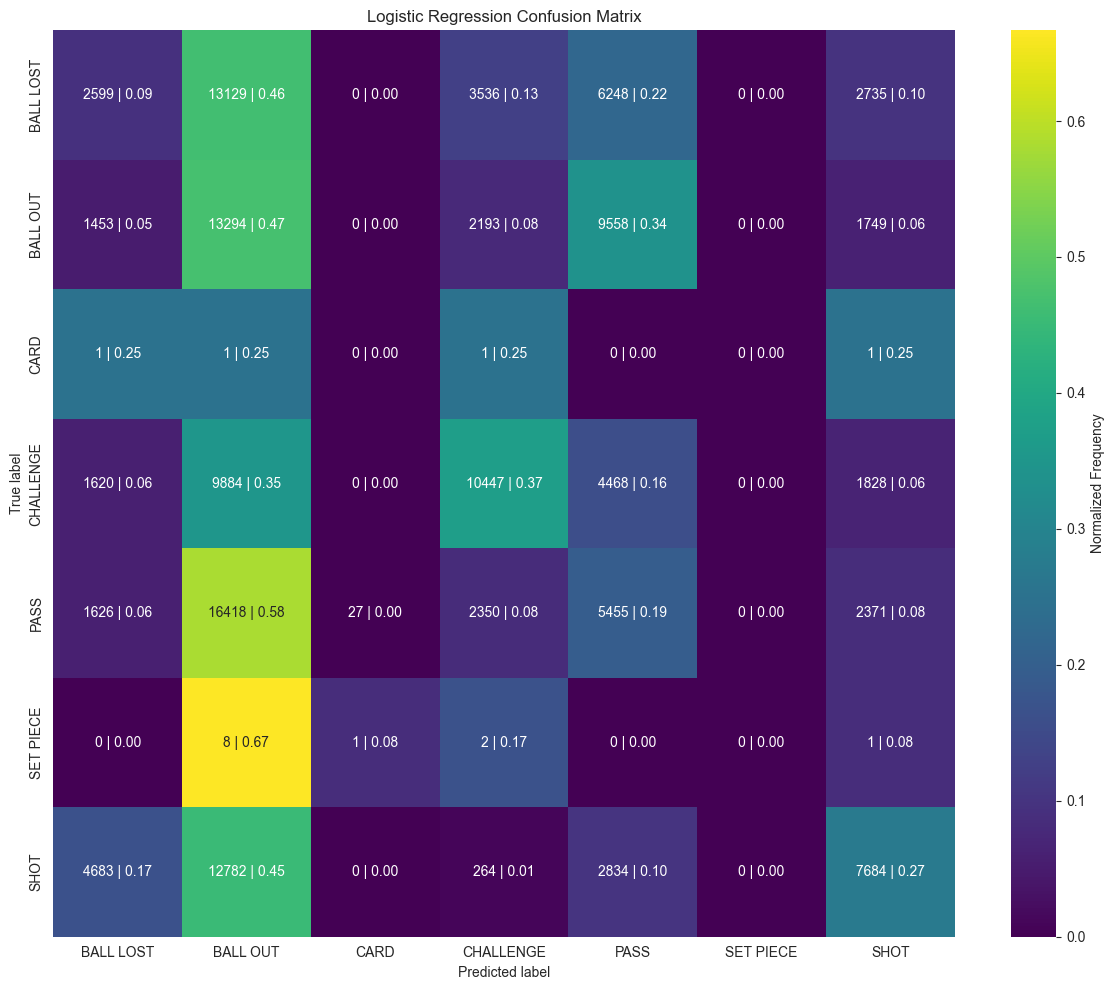

Logistic regression training accuracy: 74.52%
Logistic regression testing accuracy: 27.95%

Logistic regression testing precision: 32.72%
Logistic regression testing recall: 27.95%
Logistic regression testing f1: 27.87%


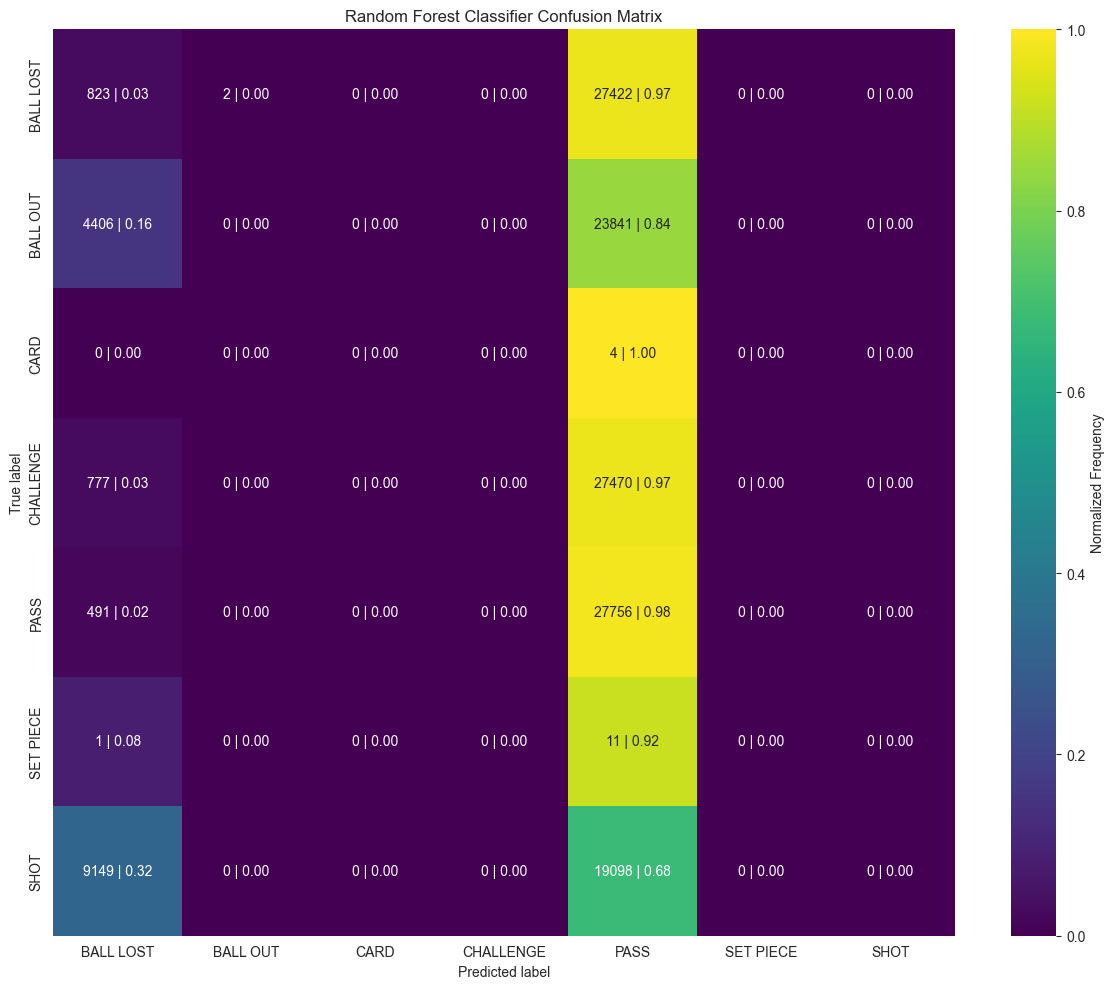

Random forest classifier training accuracy: 100.00%
Random forest classifier testing accuracy: 20.23%

Random forest classifier testing precision: 5.47%
Random forest classifier testing recall: 20.23%
Random forest classifier testing f1: 7.97%


In [56]:
inputs = [[X_1, X_2], [X_1, X_3], [X_3, X_2]]
labels = [[y_1, y_2], [y_1, y_3], [y_3, y_2]]
left_in = [X_3, X_2, X_1]
left_la = [y_3, y_2, y_1]
for i, j, k, l in zip(inputs, labels, left_in, left_la):
    for name, model in models.items():
        X = np.concatenate(i)
        y = np.concatenate((j[0], j[1]))
        
        assert X.shape[0] == y.shape[0]
        model.fit(X, y)
        
        y_pred = model.predict(X)
        y_test_pred = model.predict(k)
        
        labels = np.unique(y_1)
        
        conf_matrix(y_train=y, y_train_pred=y_pred, y_test=l, y_pred=y_test_pred, labels=labels, split=0, model_name=name)


In [63]:
import warnings
warnings.filterwarnings("ignore")

models = {
          "AdaBoost classifier": AdaBoostClassifier(algorithm="SAMME"), 
          "Logistic regression": LogisticRegression(n_jobs=-1, solver="saga"),
          "Random forest classifier": RandomForestClassifier(n_jobs=-1),  
         }

In [64]:
def run_model_trials(models, X, y, num_trials):
    for model_name, model in models.items():
        print(f"\nRunning trials for {model_name}")
        
        for trial in range(num_trials):
            if model_name == "AdaBoost classifier":
                parameters = {
                    'n_estimators': [10, 50, 100, 200],
                    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
                }
            
            elif model_name == "Logistic regression":
                parameters = {
                    'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
                    'max_iter': [100, 300, 500, 1000],
                    'penalty': ['l1', 'l2', 'elasticnet', None],
                    'solver': ['saga']
                }
                if 'elasticnet' in parameters['penalty']:
                    parameters['l1_ratio'] = [0.2, 0.4, 0.6, 0.8]
            
            elif model_name == "Random forest classifier":
                parameters = {
                    'n_estimators': [25, 50, 100, 200, 300],
                    'max_depth': [5, 10, 15, 20, 30],
                    'max_features': ['sqrt', 'log2', None],
                    'criterion': ['gini', 'entropy'],
                    'class_weight': ['balanced', None]
                }

            clf = GridSearchCV(model, parameters, cv=3, scoring='accuracy')
            clf.fit(X, y)
            print(f"Trial {trial + 1}: Best score = {clf.best_score_:.4f}")
            print(f"Best parameters: {clf.best_params_}")

# Usage
num_trials = 1
run_model_trials(models, X, y, num_trials)


Running trials for AdaBoost classifier


KeyboardInterrupt: 

In [59]:
for model_name, model in models.items():
    study = optuna.create_study(direction="maximize")

    def objective(trial):
        if model_name == "AdaBoost classifier":
            n_estimators = trial.suggest_int('n_estimators', 10, 200)
            learning_rate = trial.suggest_float('learning_rate', 0.000001, 1.0)
            model.set_params(n_estimators=n_estimators, learning_rate=learning_rate)
    
        elif model_name == "Logistic regression":
            C = trial.suggest_float('C', 1e-5, 1e5, log=True)
            max_iter = trial.suggest_int('max_iter', 10, 1000)
            penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet", None])
            if penalty == "elasticnet":
                l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
                model.set_params(C=C, max_iter=max_iter, penalty=penalty, l1_ratio=l1_ratio)
            else:
                model.set_params(C=C, max_iter=max_iter, penalty=penalty)
    
        elif model_name == "Random forest classifier":
            n_estimators = trial.suggest_int('n_estimators', 25, 300)
            max_depth = trial.suggest_int('max_depth', 5, 30)
            max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
            class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
            model.set_params(n_estimators=n_estimators, max_features=max_features, criterion=criterion, max_depth=max_depth, class_weight=class_weight)
    
        # Evaluate model with cross-validation
        score = cross_val_score(model, X, y, cv=3, scoring="accuracy").mean()
        return score
    
    study.optimize(objective, n_trials=1, show_progress_bar=True)
    best_trial = study.best_trial
    print(f"Best trial: {best_trial.params}")
    
    # Now, after finding the best hyperparameters, you can train and evaluate the model
    best_model_name = model_name
    best_model = models[best_model_name]
    
    if best_model_name == "AdaBoost classifier":
        best_model.set_params(n_estimators=best_trial.params['n_estimators'], learning_rate=best_trial.params['learning_rate'])
    elif best_model_name == "Logistic regression":
        penalty = best_trial.params['penalty']
        C = best_trial.params['C']
        max_iter = best_trial.params['max_iter']
        if penalty == "elasticnet":
            l1_ratio = best_trial.params['l1_ratio']
            best_model.set_params(C=C, max_iter=max_iter, penalty=penalty, l1_ratio=l1_ratio)
        else:
            best_model.set_params(C=C, max_iter=max_iter, penalty=penalty)
    elif best_model_name == "Random forest classifier":
        best_model.set_params(n_estimators=best_trial.params['n_estimators'], max_features=best_trial.params['max_features'], criterion=best_trial.params['criterion'], max_depth=best_trial.params['max_depth'])
    
    # Fit the best model on the data
    best_model.fit(X, y)
    
    # Predict on the training and test data
    y_pred = best_model.predict(X)
    y_3_pred = best_model.predict(X_3)
    
    train_accuracy = accuracy_score(y, y_pred)
    test_accuracy = accuracy_score(y_3, y_3_pred)
    precision = precision_score(y_3, y_3_pred, average="weighted", zero_division=0)
    recall = recall_score(y_3, y_3_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_3, y_3_pred, average="weighted", zero_division=0)
    
    print(f"{model_name} training accuracy: {train_accuracy * 100:0.2f}%")
    print(f"{model_name} testing accuracy: {test_accuracy * 100:0.2f}%\n")   
    print(f"{model_name} testing precision: {precision * 100:0.2f}%")
    print(f"{model_name} testing recall: {recall * 100:0.2f}%")
    print(f"{model_name} testing f1: {f1 * 100:0.2f}%\n\n\n")

[I 2025-02-08 13:35:44,123] A new study created in memory with name: no-name-cf9dc969-38ad-4388-bf79-c1ab704c51ae


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-02-08 14:07:19,175] Trial 0 finished with value: 0.8352925231627338 and parameters: {'n_estimators': 282, 'max_depth': 18, 'max_features': None, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8352925231627338.
[I 2025-02-08 14:13:45,799] Trial 1 finished with value: 0.8499527925346112 and parameters: {'n_estimators': 31, 'max_depth': 16, 'max_features': None, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8499527925346112.
[I 2025-02-08 14:15:39,098] Trial 2 finished with value: 0.7190450406256034 and parameters: {'n_estimators': 295, 'max_depth': 6, 'max_features': 'sqrt', 'criterion': 'gini', 'class_weight': None}. Best is trial 1 with value: 0.8499527925346112.
[I 2025-02-08 15:03:42,184] Trial 3 finished with value: 0.8563293536856045 and parameters: {'n_estimators': 274, 'max_depth': 20, 'max_features': None, 'criterion': 'entropy', 'class_weight': None}. Best is trial 3 with value: 0.8563293536856045.
[I

H:\PAPER\flask-tika\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


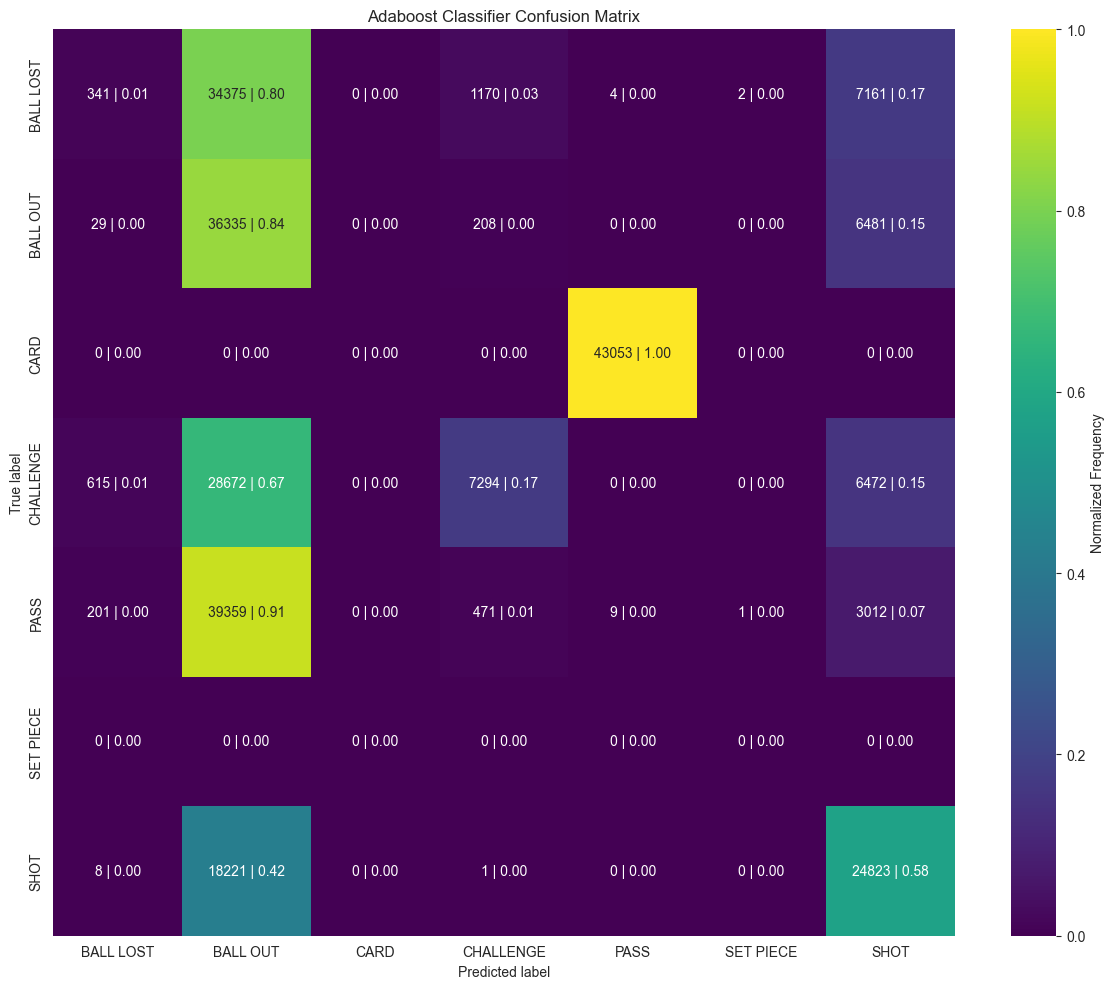

AdaBoost classifier training accuracy: 36.16%
AdaBoost classifier testing accuracy: 26.63%

AdaBoost classifier testing f1: 20.07%
AdaBoost classifier testing precision: 30.54%
AdaBoost classifier testing recall: 26.63%


H:\PAPER\flask-tika\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


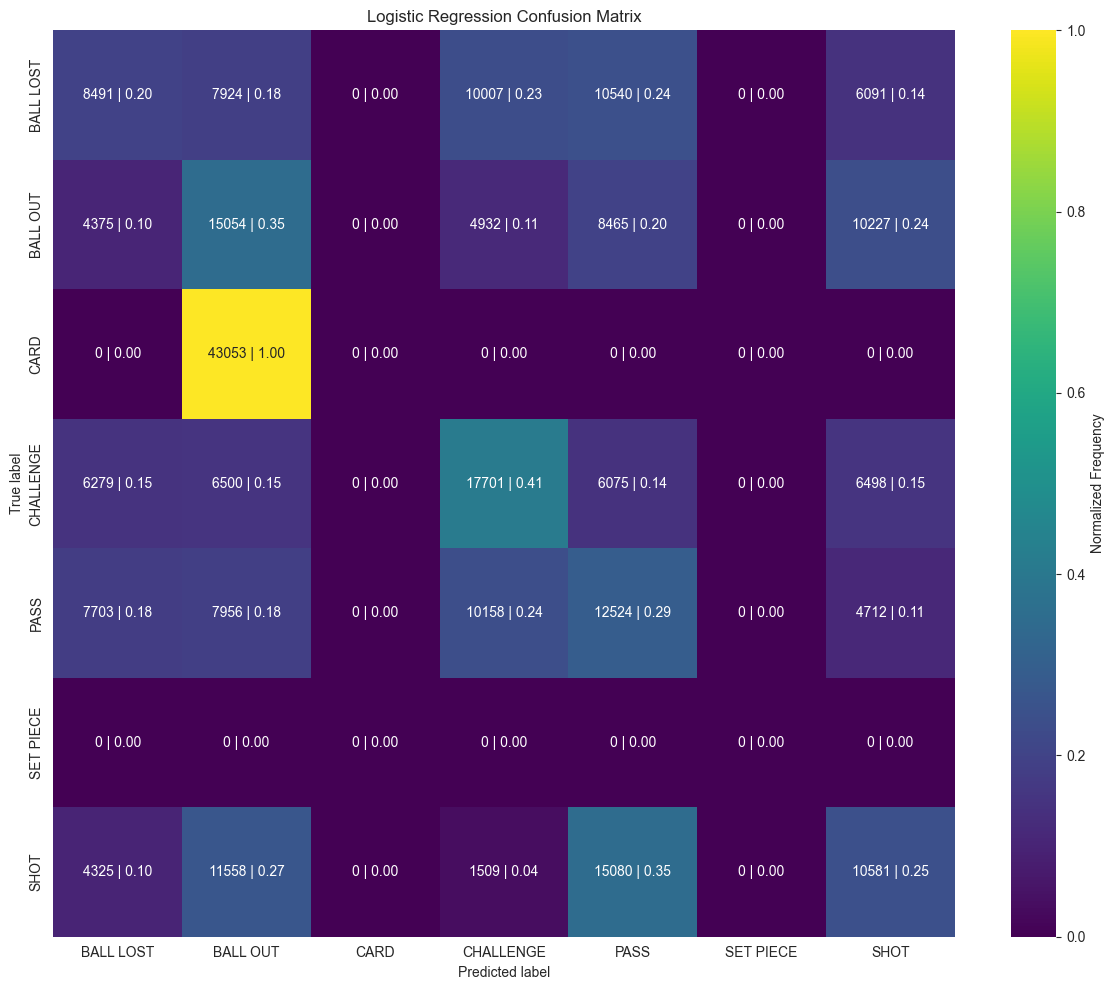

Logistic regression training accuracy: 67.86%
Logistic regression testing accuracy: 24.91%

Logistic regression testing f1: 22.99%
Logistic regression testing precision: 22.51%
Logistic regression testing recall: 24.91%


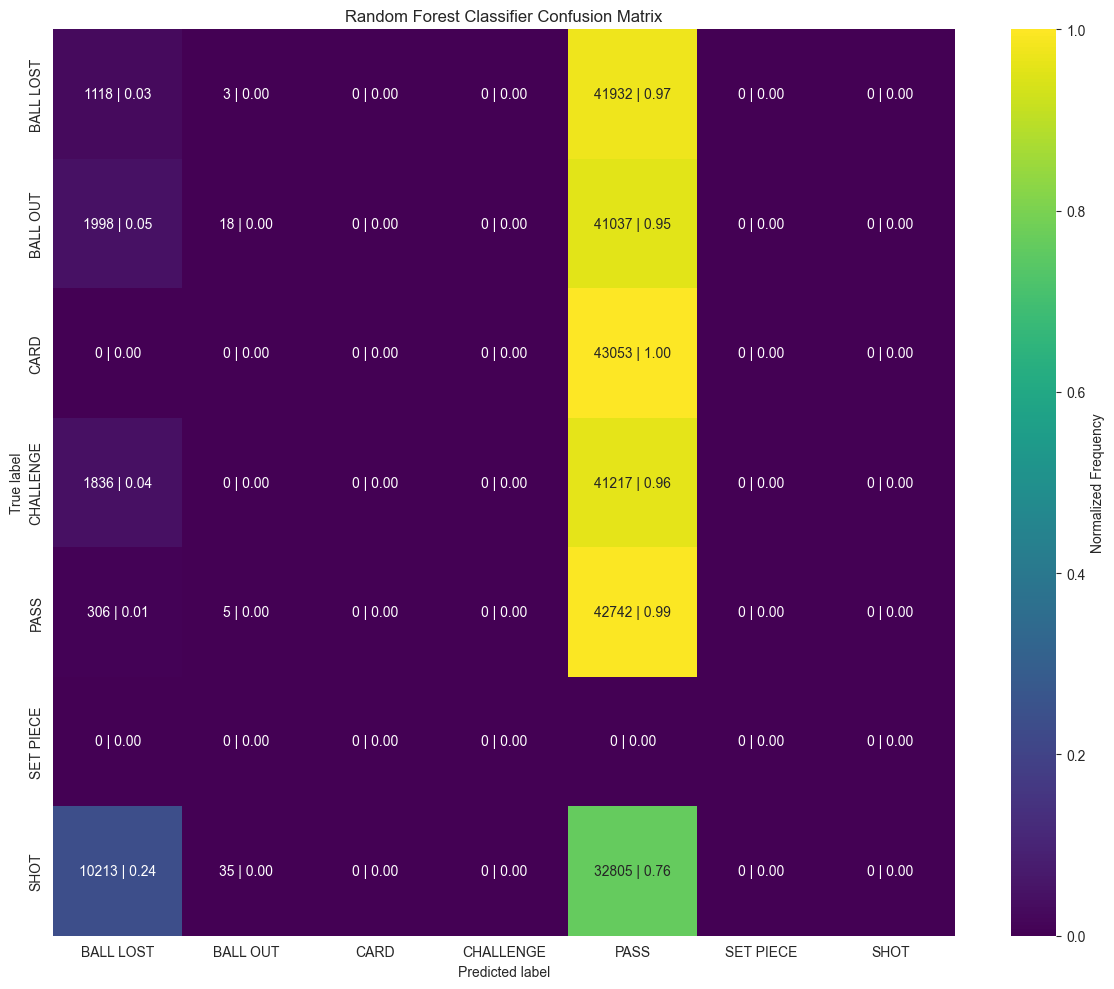

Random forest classifier training accuracy: 100.00%
Random forest classifier testing accuracy: 16.99%

Random forest classifier testing f1: 5.64%
Random forest classifier testing precision: 9.06%
Random forest classifier testing recall: 16.99%


In [66]:
for name, model in models.items():
    model.fit(X, y)
    
    y_pred = model.predict(X)
    y_3_pred = model.predict(X_3)
    
    labels = np.unique(y_1)
    
    conf_matrix(y_train=y, y_train_pred=y_pred, y_test=y_3, y_pred=y_3_pred, labels=labels, split=0, model_name=name)
